In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [164]:
csv_training_files = ['../Datasets/landsat_features_training.csv',
                          '../Datasets/terraclimate_features_training.csv',
                          '../Datasets/nasa_precip_features_training.csv',
                          '../Datasets/soil_use_data_rounded_training.csv',
                          '../Datasets/nasa_terrain_features_rounded_training.csv',
                          '../Datasets/water_quality_training_dataset.csv']

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

drop_features = ['tmax', 'tmin', 'pct_urban', 'pct_water', 'pct_wetlands', 'pct_others', 'curvature', 'elevation', 'pct_agri', 'pct_natural', 'slope']
columns_to_drop_from_features = ["Latitude", "Longitude", "Sample Date"] + drop_features

dataHandler = DataOrganizer(target_columns)
dataHandler.load_training_data(csv_training_files, columns_to_drop_from_features, scale=False)
#dataHandler.get_feature_columns()

In [167]:

Feature_data, Target_data = dataHandler.get_training_dataset()


alkalinity_target = Target_data['Total Alkalinity']
electrical_target = Target_data['Electrical Conductance']
phosphorus_target = Target_data['Dissolved Reactive Phosphorus']

full_dataset = dataHandler.get_full_training_dataset()

groups = full_dataset[["Latitude", "Longitude"]].astype(str).agg('|'.join, axis=1).values 
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)


alkalinity_train_idx, alkalinity_test_idx = next(gss.split(Feature_data, alkalinity_target, groups=groups)) 
electrical_train_idx, electrical_test_idx = next(gss.split(Feature_data, electrical_target, groups=groups)) 
phosphorous_train_idx, phosphorous_test_idx = next(gss.split(Feature_data, phosphorus_target, groups=groups))

X_train_alkalinity, X_test_alkalinity = Feature_data.iloc[alkalinity_train_idx], Feature_data.iloc[alkalinity_test_idx]
Y_train_alkalinity, Y_test_alkalinity = alkalinity_target.iloc[alkalinity_train_idx], alkalinity_target.iloc[alkalinity_test_idx]

X_train_electrical, X_test_electrical = Feature_data.iloc[electrical_train_idx], Feature_data.iloc[electrical_test_idx]
Y_train_electrical, Y_test_electrical = electrical_target.iloc[electrical_train_idx], electrical_target.iloc[electrical_test_idx]

X_train_phosphorus, X_test_phosphorus = Feature_data.iloc[phosphorous_train_idx], Feature_data.iloc[phosphorous_test_idx]
Y_train_phosphorus, Y_test_phosphorus = phosphorus_target.iloc[phosphorous_train_idx], phosphorus_target.iloc[phosphorous_test_idx]

X_train_alkalinity.columns



Index(['nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'pet',
       'rain_7d_nasa', 'rain_3d_nasa', 'rain_12d_nasa', 'month_sin'],
      dtype='object')

## XGBoost

In [ ]:
model_params = {
    'objective' :'reg:squarederror',
    'booster':'dart',
    'learning_rate' : 0.05, # bom
    'max_depth' : 3, # bom, muda comforme adicionar dados 
    'n_estimators' : 80, # bom, muda conforme adicionar dados
    'subsample' : 0.6,
    'colsample_bytree' : 0.5,
    'min_child_weight' : 30.0, ## fixado assim, bom
    'gamma' : 1.5,  ## fixado assim, bom
    'verbosity' : 1,
    'rate_drop' : 0.25, # bom : 0.25
    'skip_drop' : 0.5, # bom : 0.5
    
    'reg_lambda' : 15.0,                # L2 >= 0
    'reg_alpha' : 9.0,
}

model_alcalinity= xgb.XGBRegressor(**model_params)

model_electrical= xgb.XGBRegressor(**model_params)


model_phosphorus= xgb.XGBRegressor(**model_params)

# parametros treino:


In [ ]:

model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, y_test_alkalinity)])

model_electrical.fit(X_train_electrical, y_train_electrical,
            eval_set=[(X_test_electrical, y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, y_train_phosphorus,
            eval_set=[(X_test_phosphorus, y_test_phosphorus)])

[0]	validation_0-rmse:73.44369
[1]	validation_0-rmse:72.55091
[2]	validation_0-rmse:71.45155
[3]	validation_0-rmse:70.30933
[4]	validation_0-rmse:69.67783
[5]	validation_0-rmse:68.70890
[6]	validation_0-rmse:67.80152
[7]	validation_0-rmse:67.45330
[8]	validation_0-rmse:66.64610
[9]	validation_0-rmse:65.82099
[10]	validation_0-rmse:65.12403
[11]	validation_0-rmse:64.35228
[12]	validation_0-rmse:63.74687
[13]	validation_0-rmse:62.98176
[14]	validation_0-rmse:62.35762
[15]	validation_0-rmse:61.83248
[16]	validation_0-rmse:61.38263
[17]	validation_0-rmse:61.29211
[18]	validation_0-rmse:61.21732
[19]	validation_0-rmse:61.07570
[20]	validation_0-rmse:60.58840
[21]	validation_0-rmse:60.52384
[22]	validation_0-rmse:60.46699
[23]	validation_0-rmse:60.37598
[24]	validation_0-rmse:60.31742
[25]	validation_0-rmse:59.69117
[26]	validation_0-rmse:59.63287
[27]	validation_0-rmse:59.60319
[28]	validation_0-rmse:58.99370
[29]	validation_0-rmse:58.85379
[30]	validation_0-rmse:58.47881
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

## Random Forest

In [168]:
params = {
    'n_estimators':200,           # [100-500] Núm. de árvores. Mais é melhor, mas pesa no PC.
    'max_depth':12,                # [4-10] Profundidade. Mantenha baixo para evitar decorar o mapa.
#    'min_samples_leaf':10,        # [5-50] Mín. de amostras por folha. Ótimo contra overfitting.
    'max_features':0.5,        # ['sqrt', 'log2', 0.5] Quantas colunas cada árvore vê. 
#                                # 'sqrt' força o modelo a não depender só de Tmax/Relevo.
    'bootstrap':True,             # Usa amostras aleatórias dos dados.
    'n_jobs':-1,                  # Usa todos os núcleos do seu processador (muito rápido).
#    'random_state':42,
#    'verbose':0
}

model_alcalinity= RandomForestRegressor(**params)
    
model_electrical= RandomForestRegressor(**params)

model_phosphorus= RandomForestRegressor(**params)


In [169]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity)

model_electrical.fit(X_train_electrical, Y_train_electrical)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.5
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

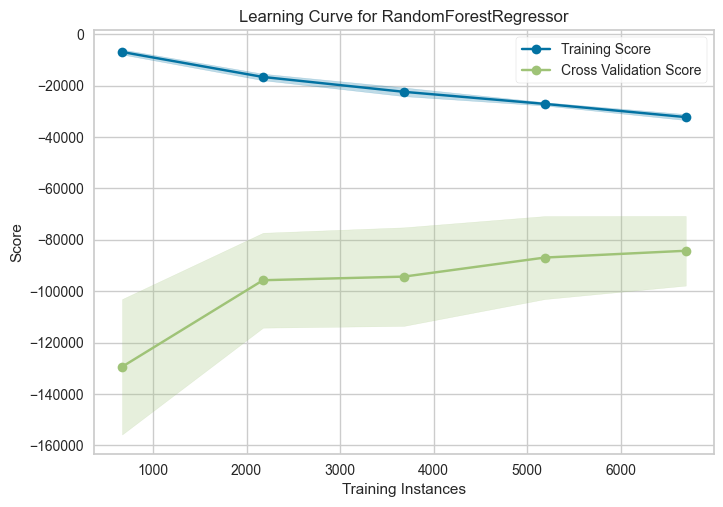

In [170]:
_ = ms.learning_curve(model_electrical, X_train_electrical, Y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

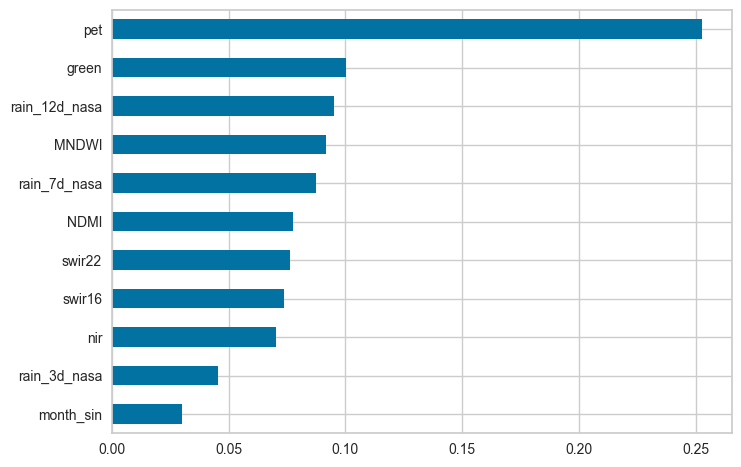

In [171]:
(pd.Series(model_alcalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

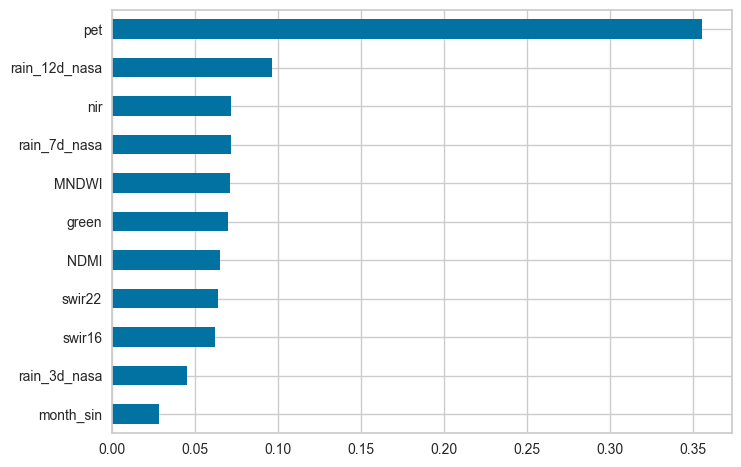

In [172]:

(pd.Series(model_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

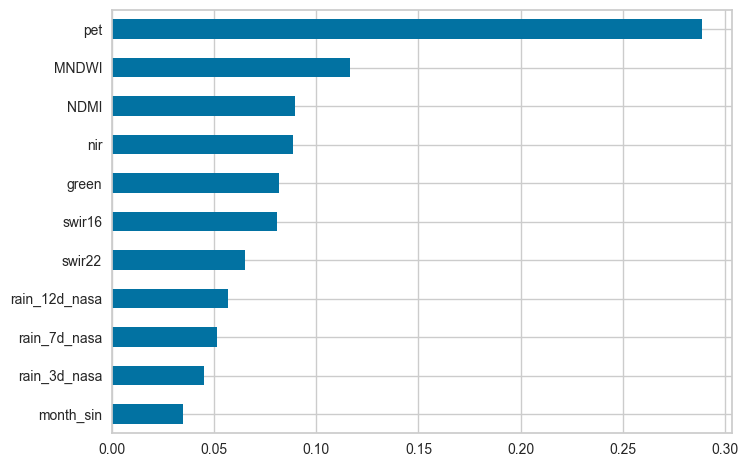

In [173]:

(pd.Series(model_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [174]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(model_phosphorus.predict(X_train_phosphorus), Y_train_phosphorus, "train evaluation")
evaluate_model(model_phosphorus.predict(X_test_phosphorus), Y_test_phosphorus, "test evaluation")

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(model_alcalinity.predict(X_train_alkalinity), Y_train_alkalinity, "train evaluation")
evaluate_model(model_alcalinity.predict(X_test_alkalinity), Y_test_alkalinity, "test evaluation")

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(model_electrical.predict(X_train_electrical), Y_train_electrical, "train evaluation")
evaluate_model(model_electrical.predict(X_test_electrical), Y_test_electrical, "test evaluation")

avaliando fosforo

train evaluation Evaluation:
R²: 0.591
RMSE: 31.387

test evaluation Evaluation:
R²: 0.145
RMSE: 58.131

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.667
RMSE: 43.203

test evaluation Evaluation:
R²: 0.263
RMSE: 61.255

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.698
RMSE: 186.141

test evaluation Evaluation:
R²: 0.188
RMSE: 327.878


(array([ 360.84234493,  255.07496433,  327.74896939,  228.43883514,
         461.81251665,  449.51615601,  533.35280339,  496.91040146,
         553.23981388,  406.87852027,  417.13619278,  417.03254834,
         471.63107738,  527.40293395,  540.13765665,  440.05606096,
         466.78436536,  462.97184008,  483.28420093,  348.20341479,
         512.96875836,  528.23319342,  449.70009209,  409.40188249,
         571.47635992,  594.41117475,  540.00318914,  556.07125675,
         491.73834293,  399.23669805,  492.54612773,  170.06255088,
         207.17302434,  293.53313024,  502.66772711,  554.95613941,
         600.48755541,  542.90722414,  501.57094979,  417.56347625,
         497.72877574,  260.61690406,  397.79965552,  517.10267886,
         553.19389721,  552.98657888,  563.97902214,  372.22303521,
         316.29304296,  552.90770048,  375.90305723,  376.11272346,
         476.54655416,  521.19128661,  226.89870592,  605.23672799,
         595.00470855,  666.97762757,  377.10798

## Submission

In [175]:
submission_csv_files = ['../Datasets/landsat_features_validation.csv',
                          '../Datasets/terraclimate_features_validation.csv',
                          '../Datasets/nasa_precip_features_validation.csv',
                          '../Datasets/soil_use_data_validation.csv',
                          '../Datasets/nasa_terrain_features_validation.csv'
]

dataHandler.load_submission_data(submission_csv_files)
all_submission_data = dataHandler.get_submission_dataset()

In [176]:

X_pred_input_features = all_submission_data

y_submission_pred_alkalinity = model_alcalinity.predict(X_pred_input_features)
y_submission_pred_electrical = model_electrical.predict(X_pred_input_features)
y_submission_pred_phosphorus = model_phosphorus.predict(X_pred_input_features)

predicted_values_dict = {
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
}


predicted_pd_final = dataHandler.build_get_submission_dataset(predicted_values_dict)

predicted_pd_final.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)
